# Demonstration of `DroneWQ` functions and processing code

## Summary 

This notebook provides an example workflow of DroneWQ using multispectral images collected by the MicaSense RedEdge-MX sensor over eastern Lake Erie on August 17, 2022. The workflow processes raw imagery to remote sensing reflectance and applies bio-optical algorithms to retrieve chlorophyll a concentrations. It georeferences the images producing a final chlorophyll a mosaic of the full dataset. 

## Contents

1. [Setup](#1.-Setup)
2. [View metadata](#2.-View-metadata)
3. [Process raw to Rrs](#3.-Process-raw-imagery-to-remote-sensing-reflectance-(Rrs)-and-visualize-data)
4. [Convert to point samples](#4.-Convert-to-point-samples)
5. [Apply bio-optical algorithms](#5.-Apply-bio-optical-algorithms)
6. [Georeference and mosaic](#6.-Georeference-and-mosaic-chlorophyll-a-images)

## 1. Setup

Pull in all the libraries needed for this notebook.

TODO: Figure out which libraries are needed here vs utils.py. Make sure utils.py libraries are all needed

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from cartopy.crs import Mercator

plt.rcParams['mathtext.default'] = 'regular'

from utils import *

Make sure your imagery has been manually organized into this exact structure (name the main_dir whatever you want but keep the rest exactly as named here):
```
    <main_dir>/
        raw_water_imgs/
        align_img/
        raw_sky_imgs/
        panel/
```

With that structure now just specify the path to your main_dir below. Here, we have the main_dir called 'Lake_Erie'.

In [2]:
project_path = os.path.join('Lake_Erie') 
project_path


'Lake_Erie'

## 2. View metadata

MicaSense raw images contain metatdata including imager information, GPS coordianates, and more. We can use the `write_metadata_csv()` function to extract image metadata and save it as .csv. 

Let's open the first five lines of the .csv to take a look.

In [7]:
write_metadata_csv(img_set = imageset.ImageSet.from_directory(project_path+'/raw_water_imgs'),
                                                            csv_output_path=project_path)

img_metadata = pd.read_csv(os.path.join(project_path, 'metadata.csv'))
img_metadata.head()

Loading ImageSet from: Lake_Erie/raw_water_imgs


,filename,dirname,DateStamp,TimeStamp,Latitude,LatitudeRef,Longitude,LongitudeRef,Altitude,SensorX,...,FocalLength,Yaw,Pitch,Roll,SolarElevation,ImageWidth,ImageHeight,XResolution,YResolution,ResolutionUnits
0,capture_1.tif,Lake_Erie/capture_1.tif,2022-08-17,15:37:04,41.828528,N,-83.398762,W,265.061,4.8,...,5.43432,218.376096,25.899967,335.837017,0.895362,1280,960,266.666667,266.666667,mm
1,capture_2.tif,Lake_Erie/capture_2.tif,2022-08-17,15:37:08,41.828670,N,-83.398764,W,265.554,4.8,...,5.43432,221.427592,16.821391,341.184053,0.895530,1280,960,266.666667,266.666667,mm
2,capture_3.tif,Lake_Erie/capture_3.tif,2022-08-17,15:37:10,41.828809,N,-83.398760,W,265.968,4.8,...,5.43432,218.898605,16.695405,343.643092,0.895655,1280,960,266.666667,266.666667,mm
3,capture_4.tif,Lake_Erie/capture_4.tif,2022-08-17,15:37:13,41.828956,N,-83.398761,W,266.420,4.8,...,5.43432,216.716936,18.188710,345.889851,0.895738,1280,960,266.666667,266.666667,mm
4,capture_5.tif,Lake_Erie/capture_5.tif,2022-08-17,15:37:16,41.829081,N,-83.398763,W,267.018,4.8,...,5.43432,214.429136,18.385695,347.772515,0.895863,1280,960,266.666667,266.666667,mm


We can plot the altitude and lat,lon location metadata of the image captures to get a sense of the flight plan.

Text(0, 0.5, 'Yaw')

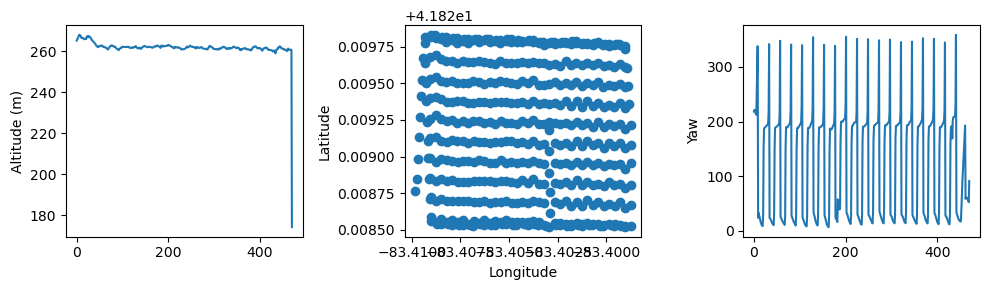

In [4]:
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='tight')

ax[0].plot(list(range(len(img_metadata))),img_metadata['Altitude'])
ax[0].set_ylabel('Altitude (m)')

ax[1].scatter(img_metadata['Longitude'], img_metadata['Latitude'])
ax[1].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')

ax[2].plot(list(range(len(img_metadata))),img_metadata['Yaw'])
ax[2].set_ylabel('Yaw')

## 3. Process raw imagery to remote sensing reflectance (Rrs) and visualize data

Now let's get to processing. 
The `process_raw_to_rrs()` function has a number of options that you can see here:

In [43]:
?process_raw_to_rrs

Signature:
process_raw_to_rrs(
    main_dir,
    rrs_dir_name,
    output_csv_path,
    lw_method='mobley_rho_method',
    mask_pixels=False,
    random_n=10,
    pixel_masking_method='value_threshold',
    mask_std_factor=1,
    nir_threshold=0.01,
    green_threshold=0.005,
    ed_method='dls_ed',
    overwrite_lt_lw=False,
    clean_intermediates=True,
)
Docstring:
This functions is the main processing script that processs raw imagery to units of remote sensing reflectance (Rrs). Users can select which processing parameters to use to calculate Rrs.

Inputs: 
main_dir: A string containing the main image directory
rrs_dir_name: A string containing the directory filepath of new rrs images
output_csv_path: A string containing the filepath to write the metadata.csv 
lw_method: Method used to calculate water leaving radiance. Default is mobley_rho_method().
random_n: The amount of random images to calculate ambient NIR level. Default is 10. Only need if lw_method = 'hedley_method'
mask_pi

For this example, we're calculating water leaving radiance (Lw) using the Hedley approach, calculating downwelling irradiance (Ed) using the downwelling light sensor (DLS). We are applying the default masking procedure. We'll save processed images out two directories called `rrs_hedley` and `masked_rrs_hedley`. Please see paper.md for more information on the different methods used here. 

In summary, this code will process: Raw -> Lt -> Lw (Hedley method) -> Rrs (using Ed from DLS) with pixel masking

In [24]:
process_raw_to_rrs(main_dir=project_path, rrs_dir_name='rrs_hedley', output_csv_path=project_path, lw_method='hedley_method', 
                   random_n=10, mask_pixels=True, pixel_masking_method='value_threshold', ed_method='dls_ed', 
                   overwrite_lt_lw=False, clean_intermediates=False)


Loading ImageSet from: Lake_Erie/align_img
Processing a total of 2356 images or 471 captures.
Converting raw images to radiance (raw -> Lt).
Loading ImageSet from: Lake_Erie/raw_water_imgs
Loading ImageSet from: Lake_Erie/align_img
used warp dir Lake_Erie/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 4
Finished aligning band 2
Finished aligning band 3
Finished aligning band 1
Saving time: 0:14:25.868902
Alignment+Saving rate: 0.54 images per second
Finished saving images.
Finished saving image metadata.
Applying the Hochberg/Hedley (Lt -> Lw)
Normalizing by DLS irradiance (Lw/Ed -> Rrs).
Loading ImageSet from: Lake_Erie/raw_water_imgs
All data has been saved as Rrs using the hedley_method to calculate Lw and normalized by dls_ed irradiance.
Masking pixels using NIR and green Rrs thresholds


True

To grab these processed images and their metadata you can use the helper function `retrieve_imgs_and_metadata()`. The images can also easily be loaded in with the lower level `load_images()` function or even just with rasterio's `open()` function but the higher level `retrieve_imgs_and_metadata()` allows you to apply an altitude cutoff and limit the number of files being opened. 

In [29]:
?retrieve_imgs_and_metadata

Signature:
retrieve_imgs_and_metadata(
    img_dir,
    count=10000,
    start=0,
    altitude_cutoff=0,
    sky=False,
    random=False,
)
Docstring:
This function is the main interface we expect the user to use when grabbing a subset of imagery from any stage in processing. This returns the images as a numpy array and metadata as a pandas dataframe. 

Inputs:
img_dir: A string containing the directory filepath of images to be retrieved
count: The amount of images you want to list. Default is 10000
start: The number of image to start on. Default is 0 (first image in img_dir). 
random: A boolean to load random images. Default is False

Outputs: A multidimensional numpy array of all image captures in a directory and a Pandas dataframe of image metadata. 
File:      /glusteruser/awindled/DroneWQ/utils.py
Type:      function

Note that this will open as many files as you ask and if you have 1000+ images this is likely more than you can load into memory. In the case of large processing jobs it will likely be more appropriate to loop through the files individually or in batches which can be done by looping the `start` and `count` arguments in `retrieve_imgs_and_metadata()`.

Let's retrieve the Rrs data (5 bands) and visualize the first 5 images:

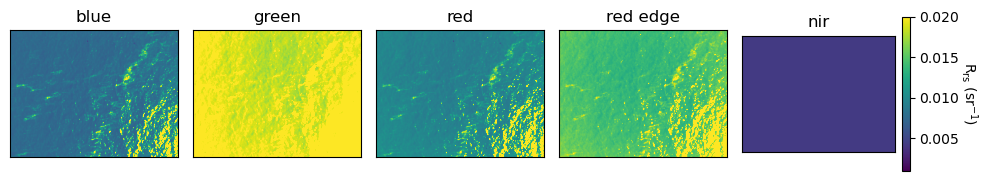

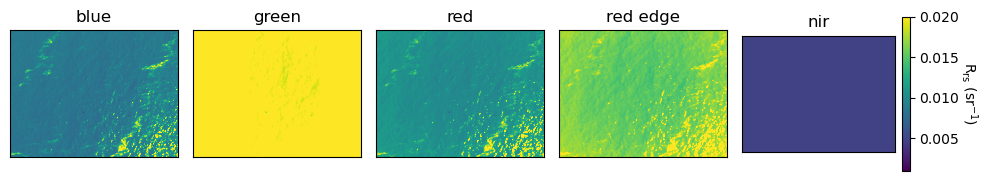

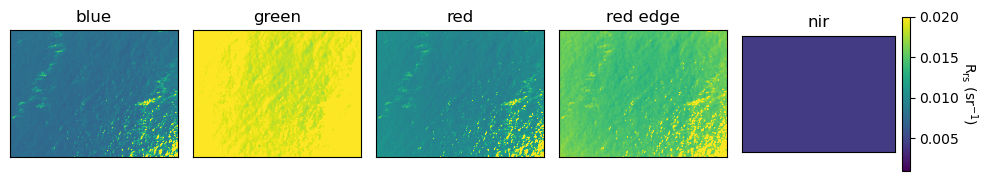

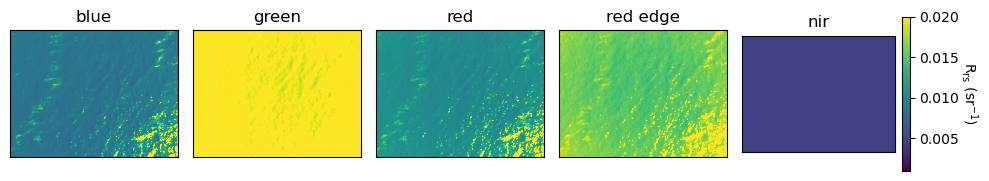

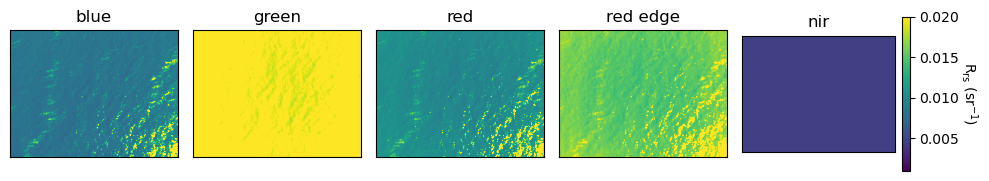

In [13]:
rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = os.path.join(project_path, 'rrs_hedley'), count=5)

band_names = ['blue', 'green', 'red', 'red edge', 'nir']

for j in range(len(rrs_imgs_hedley[0:5])):
    fig, ax = plt.subplots(1,5, figsize=(10,3.5))
    for i in range(5):
        im = ax[i].imshow(rrs_imgs_hedley[j,i], cmap='viridis', vmin=0.001, vmax=0.02)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(band_names[i])
    cbar = fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
    cbar.set_label('$R_{rs}\ (sr^{-1}$)', rotation=270, labelpad=15)
    fig.tight_layout() 
    plt.show()

We can also visualize the masked Rrs:

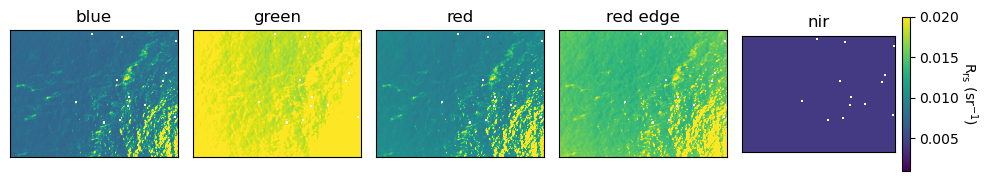

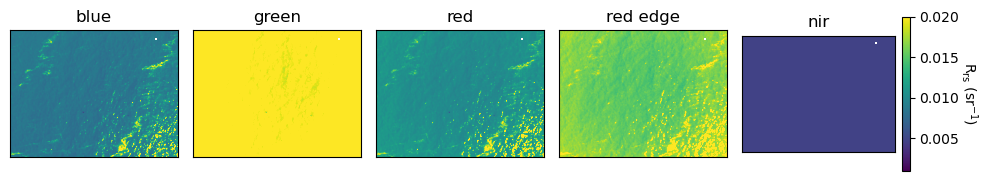

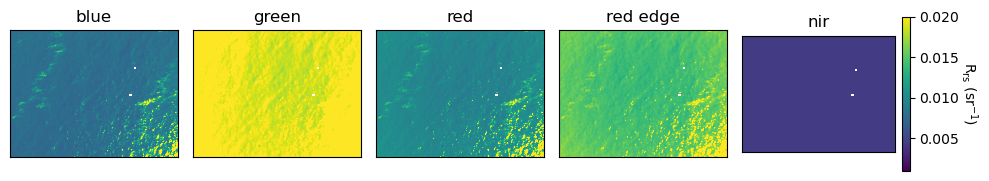

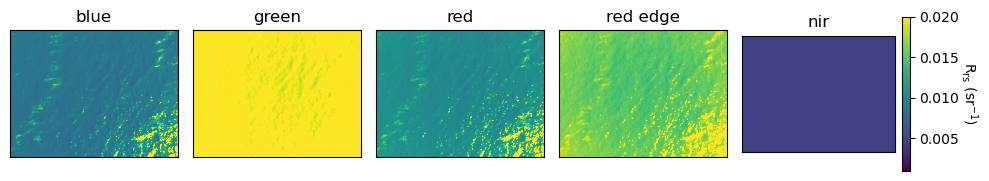

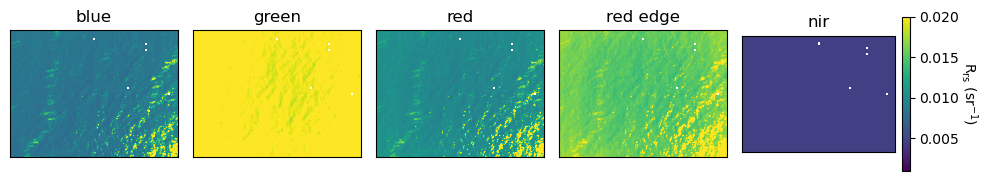

In [12]:
masked_rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = os.path.join(project_path, 'masked_rrs_hedley'), count=5)

for j in range(len(masked_rrs_imgs_hedley[0:5])):
    fig, ax = plt.subplots(1,5, figsize=(10,3.5))
    for i in range(5):
        im = ax[i].imshow(masked_rrs_imgs_hedley[j,i],cmap='viridis', vmin=0.001, vmax=0.02)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(band_names[i])
    cbar = fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
    cbar.set_label('$R_{rs}\ (sr^{-1}$)', rotation=270, labelpad=15)
    fig.tight_layout() 
    plt.show()

Let's plot the masked Rrs spectra of the first 25 images:

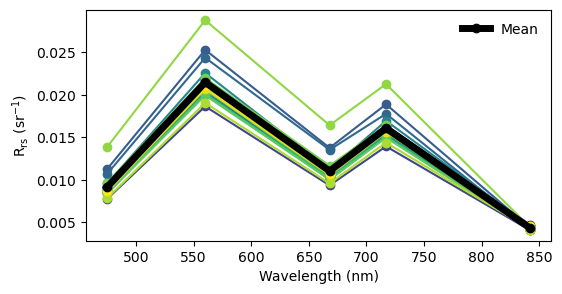

In [25]:
masked_rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = os.path.join(project_path, 'masked_rrs_hedley'), count=25)

fig, ax = plt.subplots(1,1, figsize=(6,3))

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(masked_rrs_imgs_hedley)))

for i in range(len(masked_rrs_imgs_hedley)):
    plt.plot(wv, np.nanmean(masked_rrs_imgs_hedley[i,0:5,:,:],axis=(1,2)), marker = 'o', color=colors[i], label="")
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('$R_{rs}\ (sr^{-1}$)') 
plt.plot(wv, np.nanmean(masked_rrs_imgs_hedley[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Mean')

plt.legend(frameon=False)

Let's compare this Rrs spectra to Rrs retrived by a satellite at the same location and time. Below is a plot of Rrs from the Ocean Land Color Imager (OLCI) on board the European satellite, Sentinel-3A. OLCI collects in a few more bands which is where there are more points on the plot. However, the shape looks similar to the MicaSense retrieved Rrs. The troughs at 475 nm and 668 nm is associated with chlorophyll absorption and the peak at 717 nm is likely due to phytoplankton particle scattering. 

<img src="OLCI_Rrs_Lake_Erie.png" width=560 height=500/>

Let's plot the Lt, Lw, Ed spectra as well. First, we need to retrieve all the data.

In [19]:
lt_imgs, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/lt_imgs', count=25)
lw_imgs, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/lw_imgs', count=25)
dls_ed = pd.read_csv(project_path+'/dls_ed.csv')
rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_hedley', count=25)
masked_rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/masked_rrs_hedley', count=25)

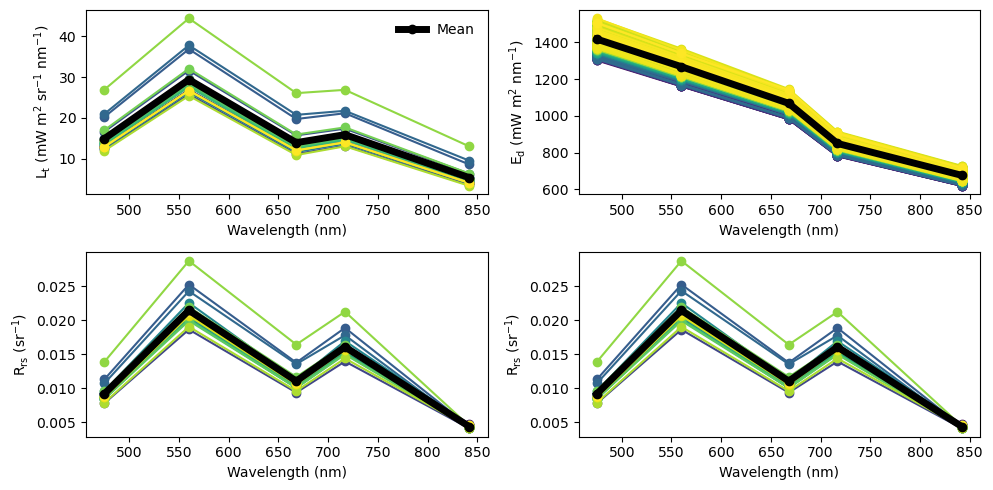

In [29]:
fig, axs = plt.subplots(2,2, figsize=(10,5))

axs = axs.ravel()

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(lt_imgs)))

#lt
for i in range(len(lt_imgs)):
    axs[0].plot(wv, np.nanmean(lt_imgs[i,0:5,:,:],axis=(1,2)),  marker = 'o', color=colors[i], label="")
    axs[0].set_xlabel('Wavelength (nm)')
    axs[0].set_ylabel('$L_t\ (mW\ m^2\ sr^{-1}\ nm^{-1}$)')   
axs[0].plot(wv, np.nanmean(lt_imgs[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Mean')
axs[0].legend(frameon=False)

#dls ed
ed = pd.read_csv(project_path+'/dls_ed.csv')
colors = plt.cm.viridis(np.linspace(0,1,len(ed)))

for i in range(len(ed)):
    axs[1].plot(wv, ed.iloc[i,1:6],  marker = 'o', color=colors[i]) 
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('$E_d\ (mW\ m^2\ nm^{-1}$)') 
axs[1].plot(wv, ed.iloc[:,1:6].mean(axis=0),  marker = 'o', color='black', linewidth=5, label='Mean')

#rrs_imgs_hedley
colors = plt.cm.viridis(np.linspace(0,1,len(rrs_imgs_hedley)))

for i in range(len(rrs_imgs_hedley)):
    axs[2].plot(wv, np.nanmean(rrs_imgs_hedley[i,0:5,:,:],axis=(1,2)),  marker = 'o', color=colors[i], label="")
    axs[2].set_xlabel('Wavelength (nm)')
    axs[2].set_ylabel('$R_{rs}\ (sr^{-1}$)') 
axs[2].plot(wv, np.nanmean(rrs_imgs_hedley[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Mean')


#rrs_imgs_hedley_masked
colors = plt.cm.viridis(np.linspace(0,1,len(masked_rrs_imgs_hedley)))

for i in range(len(masked_rrs_imgs_hedley)):
    axs[3].plot(wv, np.nanmean(masked_rrs_imgs_hedley[i,0:5,:,:],axis=(1,2)),  marker = 'o', color=colors[i], label="")
    axs[3].set_xlabel('Wavelength (nm)')
    axs[3].set_ylabel('$R_{rs}\ (sr^{-1}$)')   
axs[3].plot(wv, np.nanmean(masked_rrs_imgs_hedley[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Mean')

fig.tight_layout() 


## 4. Convert to point samples

You might be interested in averaging values for every image, to work with point samples. This code calculates the mean Rrs across bands and saves them to a Pandas dataframe with the dirname, lat, and lon.

TODO: Should this be median?

In [42]:
masked_rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/masked_rrs_hedley')

rrs_blue = []
rrs_green = []
rrs_red = []
rrs_rededge = []
rrs_nir= []

for i in range(len(masked_rrs_imgs_hedley)):
    rrs_blue.append(np.nanmean(masked_rrs_imgs_hedley[i,0,:,:]))
    rrs_green.append(np.nanmean(masked_rrs_imgs_hedley[i,1,:,:]))
    rrs_red.append(np.nanmean(masked_rrs_imgs_hedley[i,2,:,:]))
    rrs_rededge.append(np.nanmean(masked_rrs_imgs_hedley[i,3,:,:]))
    rrs_nir.append(np.nanmean(masked_rrs_imgs_hedley[i,4,:,:]))
    
df = img_metadata[['dirname', 'Latitude', 'Longitude']]
df['rrs_blue'] = rrs_blue
df['rrs_green'] = rrs_green
df['rrs_red'] = rrs_red
df['rrs_rededge'] = rrs_rededge
df['rrs_nir'] = rrs_nir    
df.head()

,dirname,Latitude,Longitude,rrs_blue,rrs_green,rrs_red,rrs_rededge,rrs_nir
filename,,,,,,,,
capture_1.tif,Lake_Erie/capture_1.tif,41.828528,-83.398762,0.008806,0.020854,0.010818,0.015645,0.004233
capture_2.tif,Lake_Erie/capture_2.tif,41.828670,-83.398764,0.009216,0.021905,0.011101,0.016410,0.004720
capture_3.tif,Lake_Erie/capture_3.tif,41.828809,-83.398760,0.008499,0.020263,0.010373,0.015263,0.004363
capture_4.tif,Lake_Erie/capture_4.tif,41.828956,-83.398761,0.009174,0.021638,0.010978,0.016261,0.004599
capture_5.tif,Lake_Erie/capture_5.tif,41.829081,-83.398763,0.009089,0.021489,0.010845,0.016147,0.004574


Easy to save as a .csv:

In [43]:
df.to_csv(project_path + '/mean_rrs.csv')

## 5. Apply bio-optical algorithms

We can also apply bio-optical algorithms to derive chlorophyll a and total suspended matter (TSM) concentrations. See the paper.md for more information on each algorithm. Here, we are applying the blended NASA chlorophyll a algorithm (Hu et al., 2019). 

In [44]:
chl_hu_ocx_imgs = chl_hu_ocx(Rrsblue=masked_rrs_imgs_hedley[:,0,:,:], 
                             Rrsgreen=masked_rrs_imgs_hedley[:,1,:,:], 
                             Rrsred=masked_rrs_imgs_hedley[:,2,:,:])
print(chl_hu_ocx_imgs.shape)

(471, 928, 1227)


Let's take a quick look at a histogram of all chl values:

10.672416


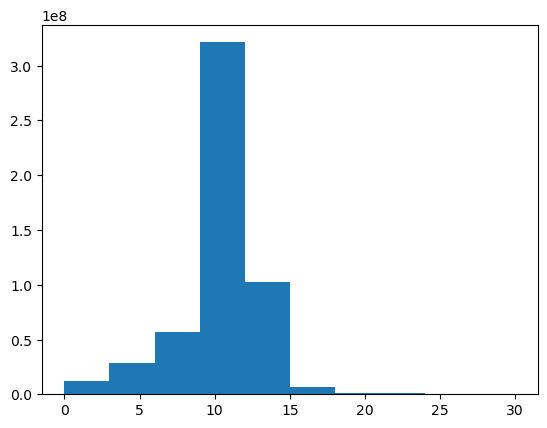

In [45]:
plt.hist(chl_hu_ocx_imgs.ravel(), range=[0, 30])
print(np.nanmedian(chl_hu_ocx_imgs))

The median value looks to be around 11 mg $m^{-3}$, which is reasonable for inland waters. 

Now, we can save new .tifs processed with this algorithm. 

TODO: get rid of italics here ^^

TODO: make one progress bar, not one for every capture

In [47]:
save_wq_imgs(main_dir=project_path, rrs_img_dir='masked_rrs_hedley', 
             wq_dir_name='chl_hu_ocx_imgs', wq_alg ='chl_hu_ocx') 

Processing images from capture_1.tif to capture_1.tif


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Processing images from capture_2.tif to capture_2.tif


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Processing images from capture_3.tif to capture_3.tif


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Processing images from capture_4.tif to capture_4.tif


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Processing images from capture_5.tif to capture_5.tif


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Processing images from capture_6.tif to capture_6.tif


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Processing images from capture_7.tif to capture_7.tif


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Processing images from capture_8.tif to capture_8.tif


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Processing images from capture_9.tif to capture_9.tif


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Processing images from capture_10.tif to capture_10.tif


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Processing images from capture_11.tif to capture_11.tif


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Processing images from capture_12.tif to capture_12.tif


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Processing images from capture_13.tif to capture_13.tif


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Processing images from capture_14.tif to capture_14.tif


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Processing images from capture_15.tif to capture_15.tif


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Processing images from capture_16.tif to capture_16.tif


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Processing images from capture_17.tif to capture_17.tif


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Processing images from capture_18.tif to capture_18.tif


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Processing images from capture_19.tif to capture_19.tif


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Processing images from capture_20.tif to capture_20.tif


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Processing images from capture_21.tif to capture_21.tif


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Processing images from capture_22.tif to capture_22.tif


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Processing images from capture_23.tif to capture_23.tif


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


Processing images from capture_24.tif to capture_24.tif


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Processing images from capture_25.tif to capture_25.tif


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Processing images from capture_26.tif to capture_26.tif


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Processing images from capture_27.tif to capture_27.tif


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Processing images from capture_28.tif to capture_28.tif


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Processing images from capture_29.tif to capture_29.tif


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Processing images from capture_30.tif to capture_30.tif


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Processing images from capture_31.tif to capture_31.tif


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Processing images from capture_32.tif to capture_32.tif


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Processing images from capture_33.tif to capture_33.tif


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Processing images from capture_34.tif to capture_34.tif


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Processing images from capture_35.tif to capture_35.tif


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Processing images from capture_36.tif to capture_36.tif


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Processing images from capture_37.tif to capture_37.tif


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Processing images from capture_38.tif to capture_38.tif


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Processing images from capture_39.tif to capture_39.tif


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Processing images from capture_40.tif to capture_40.tif


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Processing images from capture_41.tif to capture_41.tif


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Processing images from capture_42.tif to capture_42.tif


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Processing images from capture_43.tif to capture_43.tif


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Processing images from capture_44.tif to capture_44.tif


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Processing images from capture_45.tif to capture_45.tif


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Processing images from capture_46.tif to capture_46.tif


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Processing images from capture_47.tif to capture_47.tif


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Processing images from capture_48.tif to capture_48.tif


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Processing images from capture_49.tif to capture_49.tif


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Processing images from capture_50.tif to capture_50.tif


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Processing images from capture_51.tif to capture_51.tif


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Processing images from capture_52.tif to capture_52.tif


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Processing images from capture_53.tif to capture_53.tif


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Processing images from capture_54.tif to capture_54.tif


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Processing images from capture_55.tif to capture_55.tif


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Processing images from capture_56.tif to capture_56.tif


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Processing images from capture_57.tif to capture_57.tif


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Processing images from capture_58.tif to capture_58.tif


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Processing images from capture_59.tif to capture_59.tif


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Processing images from capture_60.tif to capture_60.tif


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Processing images from capture_61.tif to capture_61.tif


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Processing images from capture_62.tif to capture_62.tif


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Processing images from capture_63.tif to capture_63.tif


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Processing images from capture_64.tif to capture_64.tif


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Processing images from capture_65.tif to capture_65.tif


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Processing images from capture_66.tif to capture_66.tif


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Processing images from capture_67.tif to capture_67.tif


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Processing images from capture_68.tif to capture_68.tif


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Processing images from capture_69.tif to capture_69.tif


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Processing images from capture_70.tif to capture_70.tif


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Processing images from capture_71.tif to capture_71.tif


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Processing images from capture_72.tif to capture_72.tif


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Processing images from capture_73.tif to capture_73.tif


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Processing images from capture_74.tif to capture_74.tif


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Processing images from capture_75.tif to capture_75.tif


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Processing images from capture_76.tif to capture_76.tif


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Processing images from capture_77.tif to capture_77.tif


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Processing images from capture_78.tif to capture_78.tif


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Processing images from capture_79.tif to capture_79.tif


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Processing images from capture_80.tif to capture_80.tif


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Processing images from capture_81.tif to capture_81.tif


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Processing images from capture_82.tif to capture_82.tif


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Processing images from capture_83.tif to capture_83.tif


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Processing images from capture_84.tif to capture_84.tif


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Processing images from capture_85.tif to capture_85.tif


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Processing images from capture_86.tif to capture_86.tif


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Processing images from capture_87.tif to capture_87.tif


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Processing images from capture_88.tif to capture_88.tif


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Processing images from capture_89.tif to capture_89.tif


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Processing images from capture_90.tif to capture_90.tif


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Processing images from capture_91.tif to capture_91.tif


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Processing images from capture_92.tif to capture_92.tif


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Processing images from capture_93.tif to capture_93.tif


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Processing images from capture_94.tif to capture_94.tif


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Processing images from capture_95.tif to capture_95.tif


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Processing images from capture_96.tif to capture_96.tif


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Processing images from capture_97.tif to capture_97.tif


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Processing images from capture_98.tif to capture_98.tif


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Processing images from capture_99.tif to capture_99.tif


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Processing images from capture_100.tif to capture_100.tif


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Processing images from capture_101.tif to capture_101.tif


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Processing images from capture_102.tif to capture_102.tif


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Processing images from capture_103.tif to capture_103.tif


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Processing images from capture_104.tif to capture_104.tif


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Processing images from capture_105.tif to capture_105.tif


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Processing images from capture_106.tif to capture_106.tif


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Processing images from capture_107.tif to capture_107.tif


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Processing images from capture_108.tif to capture_108.tif


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Processing images from capture_109.tif to capture_109.tif


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Processing images from capture_110.tif to capture_110.tif


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Processing images from capture_111.tif to capture_111.tif


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Processing images from capture_112.tif to capture_112.tif


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Processing images from capture_113.tif to capture_113.tif


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Processing images from capture_114.tif to capture_114.tif


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Processing images from capture_115.tif to capture_115.tif


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Processing images from capture_116.tif to capture_116.tif


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Processing images from capture_117.tif to capture_117.tif


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Processing images from capture_118.tif to capture_118.tif


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Processing images from capture_119.tif to capture_119.tif


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Processing images from capture_120.tif to capture_120.tif


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Processing images from capture_121.tif to capture_121.tif


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Processing images from capture_122.tif to capture_122.tif


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Processing images from capture_123.tif to capture_123.tif


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Processing images from capture_124.tif to capture_124.tif


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Processing images from capture_125.tif to capture_125.tif


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Processing images from capture_126.tif to capture_126.tif


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Processing images from capture_127.tif to capture_127.tif


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Processing images from capture_128.tif to capture_128.tif


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Processing images from capture_129.tif to capture_129.tif


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Processing images from capture_130.tif to capture_130.tif


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Processing images from capture_131.tif to capture_131.tif


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Processing images from capture_132.tif to capture_132.tif


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Processing images from capture_133.tif to capture_133.tif


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Processing images from capture_134.tif to capture_134.tif


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Processing images from capture_135.tif to capture_135.tif


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Processing images from capture_136.tif to capture_136.tif


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Processing images from capture_137.tif to capture_137.tif


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Processing images from capture_138.tif to capture_138.tif


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Processing images from capture_139.tif to capture_139.tif


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Processing images from capture_140.tif to capture_140.tif


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Processing images from capture_141.tif to capture_141.tif


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Processing images from capture_142.tif to capture_142.tif


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Processing images from capture_143.tif to capture_143.tif


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Processing images from capture_144.tif to capture_144.tif


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Processing images from capture_145.tif to capture_145.tif


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Processing images from capture_146.tif to capture_146.tif


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Processing images from capture_147.tif to capture_147.tif


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Processing images from capture_148.tif to capture_148.tif


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Processing images from capture_149.tif to capture_149.tif


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Processing images from capture_150.tif to capture_150.tif


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Processing images from capture_151.tif to capture_151.tif


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Processing images from capture_152.tif to capture_152.tif


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Processing images from capture_153.tif to capture_153.tif


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Processing images from capture_154.tif to capture_154.tif


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Processing images from capture_155.tif to capture_155.tif


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Processing images from capture_156.tif to capture_156.tif


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Processing images from capture_157.tif to capture_157.tif


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Processing images from capture_158.tif to capture_158.tif


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Processing images from capture_159.tif to capture_159.tif


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Processing images from capture_160.tif to capture_160.tif


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Processing images from capture_161.tif to capture_161.tif


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Processing images from capture_162.tif to capture_162.tif


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Processing images from capture_163.tif to capture_163.tif


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Processing images from capture_164.tif to capture_164.tif


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Processing images from capture_165.tif to capture_165.tif


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Processing images from capture_166.tif to capture_166.tif


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Processing images from capture_167.tif to capture_167.tif


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Processing images from capture_168.tif to capture_168.tif


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Processing images from capture_169.tif to capture_169.tif


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


Processing images from capture_170.tif to capture_170.tif


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Processing images from capture_171.tif to capture_171.tif


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Processing images from capture_172.tif to capture_172.tif


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Processing images from capture_173.tif to capture_173.tif


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Processing images from capture_174.tif to capture_174.tif


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Processing images from capture_175.tif to capture_175.tif


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Processing images from capture_176.tif to capture_176.tif


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Processing images from capture_177.tif to capture_177.tif


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Processing images from capture_178.tif to capture_178.tif


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Processing images from capture_179.tif to capture_179.tif


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Processing images from capture_180.tif to capture_180.tif


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Processing images from capture_181.tif to capture_181.tif


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Processing images from capture_182.tif to capture_182.tif


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Processing images from capture_183.tif to capture_183.tif


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Processing images from capture_184.tif to capture_184.tif


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Processing images from capture_185.tif to capture_185.tif


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Processing images from capture_186.tif to capture_186.tif


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Processing images from capture_187.tif to capture_187.tif


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Processing images from capture_188.tif to capture_188.tif


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Processing images from capture_189.tif to capture_189.tif


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Processing images from capture_190.tif to capture_190.tif


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Processing images from capture_191.tif to capture_191.tif


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Processing images from capture_192.tif to capture_192.tif


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Processing images from capture_193.tif to capture_193.tif


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Processing images from capture_194.tif to capture_194.tif


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Processing images from capture_195.tif to capture_195.tif


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Processing images from capture_196.tif to capture_196.tif


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Processing images from capture_197.tif to capture_197.tif


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Processing images from capture_198.tif to capture_198.tif


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Processing images from capture_199.tif to capture_199.tif


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Processing images from capture_200.tif to capture_200.tif


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Processing images from capture_201.tif to capture_201.tif


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Processing images from capture_202.tif to capture_202.tif


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Processing images from capture_203.tif to capture_203.tif


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Processing images from capture_204.tif to capture_204.tif


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Processing images from capture_205.tif to capture_205.tif


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Processing images from capture_206.tif to capture_206.tif


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Processing images from capture_207.tif to capture_207.tif


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Processing images from capture_208.tif to capture_208.tif


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Processing images from capture_209.tif to capture_209.tif


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Processing images from capture_210.tif to capture_210.tif


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Processing images from capture_211.tif to capture_211.tif


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Processing images from capture_212.tif to capture_212.tif


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Processing images from capture_213.tif to capture_213.tif


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Processing images from capture_214.tif to capture_214.tif


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Processing images from capture_215.tif to capture_215.tif


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Processing images from capture_216.tif to capture_216.tif


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Processing images from capture_217.tif to capture_217.tif


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Processing images from capture_218.tif to capture_218.tif


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Processing images from capture_219.tif to capture_219.tif


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Processing images from capture_220.tif to capture_220.tif


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Processing images from capture_221.tif to capture_221.tif


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Processing images from capture_222.tif to capture_222.tif


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Processing images from capture_223.tif to capture_223.tif


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Processing images from capture_224.tif to capture_224.tif


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Processing images from capture_225.tif to capture_225.tif


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Processing images from capture_226.tif to capture_226.tif


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Processing images from capture_227.tif to capture_227.tif


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Processing images from capture_228.tif to capture_228.tif


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Processing images from capture_229.tif to capture_229.tif


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Processing images from capture_230.tif to capture_230.tif


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Processing images from capture_231.tif to capture_231.tif


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Processing images from capture_232.tif to capture_232.tif


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Processing images from capture_233.tif to capture_233.tif


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Processing images from capture_234.tif to capture_234.tif


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


Processing images from capture_235.tif to capture_235.tif


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Processing images from capture_236.tif to capture_236.tif


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Processing images from capture_237.tif to capture_237.tif


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Processing images from capture_238.tif to capture_238.tif


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Processing images from capture_239.tif to capture_239.tif


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Processing images from capture_240.tif to capture_240.tif


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Processing images from capture_241.tif to capture_241.tif


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Processing images from capture_242.tif to capture_242.tif


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Processing images from capture_243.tif to capture_243.tif


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Processing images from capture_244.tif to capture_244.tif


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Processing images from capture_245.tif to capture_245.tif


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Processing images from capture_246.tif to capture_246.tif


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Processing images from capture_247.tif to capture_247.tif


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Processing images from capture_248.tif to capture_248.tif


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Processing images from capture_249.tif to capture_249.tif


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Processing images from capture_250.tif to capture_250.tif


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Processing images from capture_251.tif to capture_251.tif


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Processing images from capture_252.tif to capture_252.tif


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Processing images from capture_253.tif to capture_253.tif


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Processing images from capture_254.tif to capture_254.tif


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Processing images from capture_255.tif to capture_255.tif


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Processing images from capture_256.tif to capture_256.tif


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Processing images from capture_257.tif to capture_257.tif


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Processing images from capture_258.tif to capture_258.tif


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Processing images from capture_259.tif to capture_259.tif


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Processing images from capture_260.tif to capture_260.tif


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Processing images from capture_261.tif to capture_261.tif


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Processing images from capture_262.tif to capture_262.tif


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Processing images from capture_263.tif to capture_263.tif


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Processing images from capture_264.tif to capture_264.tif


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Processing images from capture_265.tif to capture_265.tif


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Processing images from capture_266.tif to capture_266.tif


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Processing images from capture_267.tif to capture_267.tif


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Processing images from capture_268.tif to capture_268.tif


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Processing images from capture_269.tif to capture_269.tif


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Processing images from capture_270.tif to capture_270.tif


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Processing images from capture_271.tif to capture_271.tif


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Processing images from capture_272.tif to capture_272.tif


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Processing images from capture_273.tif to capture_273.tif


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Processing images from capture_274.tif to capture_274.tif


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Processing images from capture_275.tif to capture_275.tif


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Processing images from capture_276.tif to capture_276.tif


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Processing images from capture_277.tif to capture_277.tif


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Processing images from capture_278.tif to capture_278.tif


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Processing images from capture_279.tif to capture_279.tif


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Processing images from capture_280.tif to capture_280.tif


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Processing images from capture_281.tif to capture_281.tif


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Processing images from capture_282.tif to capture_282.tif


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Processing images from capture_283.tif to capture_283.tif


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Processing images from capture_284.tif to capture_284.tif


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Processing images from capture_285.tif to capture_285.tif


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Processing images from capture_286.tif to capture_286.tif


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Processing images from capture_287.tif to capture_287.tif


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Processing images from capture_288.tif to capture_288.tif


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Processing images from capture_289.tif to capture_289.tif


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Processing images from capture_290.tif to capture_290.tif


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Processing images from capture_291.tif to capture_291.tif


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Processing images from capture_292.tif to capture_292.tif


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Processing images from capture_293.tif to capture_293.tif


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Processing images from capture_294.tif to capture_294.tif


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Processing images from capture_295.tif to capture_295.tif


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Processing images from capture_296.tif to capture_296.tif


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Processing images from capture_297.tif to capture_297.tif


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Processing images from capture_298.tif to capture_298.tif


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Processing images from capture_299.tif to capture_299.tif


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


Processing images from capture_300.tif to capture_300.tif


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Processing images from capture_301.tif to capture_301.tif


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Processing images from capture_302.tif to capture_302.tif


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Processing images from capture_303.tif to capture_303.tif


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Processing images from capture_304.tif to capture_304.tif


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Processing images from capture_305.tif to capture_305.tif


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Processing images from capture_306.tif to capture_306.tif


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Processing images from capture_307.tif to capture_307.tif


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Processing images from capture_308.tif to capture_308.tif


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Processing images from capture_309.tif to capture_309.tif


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Processing images from capture_310.tif to capture_310.tif


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Processing images from capture_311.tif to capture_311.tif


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Processing images from capture_312.tif to capture_312.tif


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Processing images from capture_313.tif to capture_313.tif


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Processing images from capture_314.tif to capture_314.tif


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Processing images from capture_315.tif to capture_315.tif


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Processing images from capture_316.tif to capture_316.tif


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Processing images from capture_317.tif to capture_317.tif


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Processing images from capture_318.tif to capture_318.tif


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Processing images from capture_319.tif to capture_319.tif


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Processing images from capture_320.tif to capture_320.tif


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Processing images from capture_321.tif to capture_321.tif


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Processing images from capture_322.tif to capture_322.tif


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Processing images from capture_323.tif to capture_323.tif


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Processing images from capture_324.tif to capture_324.tif


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Processing images from capture_325.tif to capture_325.tif


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Processing images from capture_326.tif to capture_326.tif


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Processing images from capture_327.tif to capture_327.tif


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Processing images from capture_328.tif to capture_328.tif


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Processing images from capture_329.tif to capture_329.tif


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Processing images from capture_330.tif to capture_330.tif


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Processing images from capture_331.tif to capture_331.tif


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Processing images from capture_332.tif to capture_332.tif


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Processing images from capture_333.tif to capture_333.tif


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Processing images from capture_334.tif to capture_334.tif


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Processing images from capture_335.tif to capture_335.tif


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Processing images from capture_336.tif to capture_336.tif


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Processing images from capture_337.tif to capture_337.tif


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Processing images from capture_338.tif to capture_338.tif


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Processing images from capture_339.tif to capture_339.tif


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Processing images from capture_340.tif to capture_340.tif


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Processing images from capture_341.tif to capture_341.tif


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Processing images from capture_342.tif to capture_342.tif


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Processing images from capture_343.tif to capture_343.tif


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Processing images from capture_344.tif to capture_344.tif


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Processing images from capture_345.tif to capture_345.tif


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Processing images from capture_346.tif to capture_346.tif


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Processing images from capture_347.tif to capture_347.tif


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Processing images from capture_348.tif to capture_348.tif


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Processing images from capture_349.tif to capture_349.tif


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Processing images from capture_350.tif to capture_350.tif


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Processing images from capture_351.tif to capture_351.tif


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Processing images from capture_352.tif to capture_352.tif


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Processing images from capture_353.tif to capture_353.tif


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Processing images from capture_354.tif to capture_354.tif


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Processing images from capture_355.tif to capture_355.tif


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Processing images from capture_356.tif to capture_356.tif


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Processing images from capture_357.tif to capture_357.tif


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Processing images from capture_358.tif to capture_358.tif


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Processing images from capture_359.tif to capture_359.tif


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Processing images from capture_360.tif to capture_360.tif


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Processing images from capture_361.tif to capture_361.tif


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Processing images from capture_362.tif to capture_362.tif


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Processing images from capture_363.tif to capture_363.tif


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Processing images from capture_364.tif to capture_364.tif


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Processing images from capture_365.tif to capture_365.tif


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Processing images from capture_366.tif to capture_366.tif


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Processing images from capture_367.tif to capture_367.tif


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Processing images from capture_368.tif to capture_368.tif


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Processing images from capture_369.tif to capture_369.tif


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Processing images from capture_370.tif to capture_370.tif


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Processing images from capture_371.tif to capture_371.tif


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Processing images from capture_372.tif to capture_372.tif


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Processing images from capture_373.tif to capture_373.tif


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Processing images from capture_374.tif to capture_374.tif


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Processing images from capture_375.tif to capture_375.tif


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Processing images from capture_376.tif to capture_376.tif


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Processing images from capture_377.tif to capture_377.tif


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Processing images from capture_378.tif to capture_378.tif


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Processing images from capture_379.tif to capture_379.tif


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Processing images from capture_380.tif to capture_380.tif


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Processing images from capture_381.tif to capture_381.tif


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Processing images from capture_382.tif to capture_382.tif


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Processing images from capture_383.tif to capture_383.tif


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Processing images from capture_384.tif to capture_384.tif


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Processing images from capture_385.tif to capture_385.tif


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Processing images from capture_386.tif to capture_386.tif


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Processing images from capture_387.tif to capture_387.tif


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Processing images from capture_388.tif to capture_388.tif


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Processing images from capture_389.tif to capture_389.tif


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Processing images from capture_390.tif to capture_390.tif


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Processing images from capture_391.tif to capture_391.tif


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Processing images from capture_392.tif to capture_392.tif


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Processing images from capture_393.tif to capture_393.tif


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Processing images from capture_394.tif to capture_394.tif


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Processing images from capture_395.tif to capture_395.tif


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Processing images from capture_396.tif to capture_396.tif


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Processing images from capture_397.tif to capture_397.tif


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Processing images from capture_398.tif to capture_398.tif


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Processing images from capture_399.tif to capture_399.tif


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Processing images from capture_400.tif to capture_400.tif


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Processing images from capture_401.tif to capture_401.tif


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Processing images from capture_402.tif to capture_402.tif


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Processing images from capture_403.tif to capture_403.tif


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Processing images from capture_404.tif to capture_404.tif


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Processing images from capture_405.tif to capture_405.tif


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Processing images from capture_406.tif to capture_406.tif


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Processing images from capture_407.tif to capture_407.tif


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Processing images from capture_408.tif to capture_408.tif


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Processing images from capture_409.tif to capture_409.tif


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Processing images from capture_410.tif to capture_410.tif


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Processing images from capture_411.tif to capture_411.tif


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Processing images from capture_412.tif to capture_412.tif


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Processing images from capture_413.tif to capture_413.tif


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Processing images from capture_414.tif to capture_414.tif


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Processing images from capture_415.tif to capture_415.tif


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Processing images from capture_416.tif to capture_416.tif


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Processing images from capture_417.tif to capture_417.tif


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Processing images from capture_418.tif to capture_418.tif


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Processing images from capture_419.tif to capture_419.tif


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Processing images from capture_420.tif to capture_420.tif


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Processing images from capture_421.tif to capture_421.tif


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Processing images from capture_422.tif to capture_422.tif


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Processing images from capture_423.tif to capture_423.tif


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Processing images from capture_424.tif to capture_424.tif


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Processing images from capture_425.tif to capture_425.tif


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Processing images from capture_426.tif to capture_426.tif


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Processing images from capture_427.tif to capture_427.tif


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Processing images from capture_428.tif to capture_428.tif


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Processing images from capture_429.tif to capture_429.tif


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Processing images from capture_430.tif to capture_430.tif


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Processing images from capture_431.tif to capture_431.tif


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Processing images from capture_432.tif to capture_432.tif


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Processing images from capture_433.tif to capture_433.tif


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Processing images from capture_434.tif to capture_434.tif


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Processing images from capture_435.tif to capture_435.tif


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Processing images from capture_436.tif to capture_436.tif


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Processing images from capture_437.tif to capture_437.tif


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Processing images from capture_438.tif to capture_438.tif


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Processing images from capture_439.tif to capture_439.tif


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Processing images from capture_440.tif to capture_440.tif


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Processing images from capture_441.tif to capture_441.tif


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Processing images from capture_442.tif to capture_442.tif


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Processing images from capture_443.tif to capture_443.tif


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Processing images from capture_444.tif to capture_444.tif


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Processing images from capture_445.tif to capture_445.tif


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Processing images from capture_446.tif to capture_446.tif


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Processing images from capture_447.tif to capture_447.tif


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Processing images from capture_448.tif to capture_448.tif


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Processing images from capture_449.tif to capture_449.tif


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Processing images from capture_450.tif to capture_450.tif


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Processing images from capture_451.tif to capture_451.tif


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Processing images from capture_452.tif to capture_452.tif


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Processing images from capture_453.tif to capture_453.tif


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Processing images from capture_454.tif to capture_454.tif


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Processing images from capture_455.tif to capture_455.tif


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Processing images from capture_456.tif to capture_456.tif


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Processing images from capture_457.tif to capture_457.tif


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Processing images from capture_458.tif to capture_458.tif


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Processing images from capture_459.tif to capture_459.tif


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Processing images from capture_460.tif to capture_460.tif


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Processing images from capture_461.tif to capture_461.tif


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Processing images from capture_462.tif to capture_462.tif


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Processing images from capture_463.tif to capture_463.tif


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Processing images from capture_464.tif to capture_464.tif


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Processing images from capture_465.tif to capture_465.tif


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Processing images from capture_466.tif to capture_466.tif


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Processing images from capture_467.tif to capture_467.tif


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Processing images from capture_468.tif to capture_468.tif


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Processing images from capture_469.tif to capture_469.tif


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Processing images from capture_470.tif to capture_470.tif


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Processing images from capture_471.tif to capture_471.tif


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Let's visualize a few chl a images.

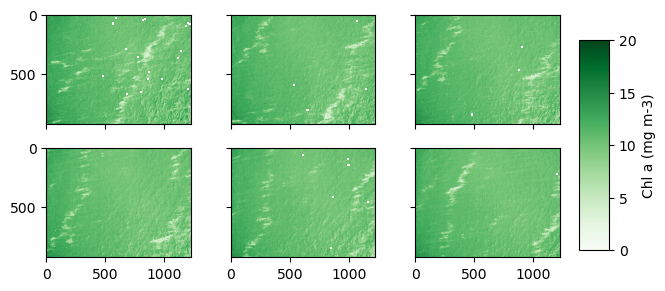

In [48]:
chl_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = os.path.join(project_path, 'chl_hu_ocx_imgs'), count=6)

fig, axs = plt.subplots(2,3, figsize=(6,3), sharex=True, sharey=True, layout='tight')

axs = axs.ravel()

for i in range(6):
    im = axs[i].imshow(chl_imgs_hedley[i,0,:,:], cmap='Greens', vmin=0, vmax=20)

cbar_ax = fig.add_axes([0.99, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Chl a (mg m-3)')

plt.show()

We can also save average chl-a/TSM concentrations for each image in dataframe to use as point data:

In [50]:
masked_rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/masked_rrs_hedley')

chl_hu_ocx_imgs = chl_hu_ocx(Rrsblue=masked_rrs_imgs_hedley[:,0,:,:], 
                             Rrsgreen=masked_rrs_imgs_hedley[:,1,:,:], 
                             Rrsred=masked_rrs_imgs_hedley[:,2,:,:])

tsm_nechad_imgs = tsm_nechad(Rrsred=masked_rrs_imgs_hedley[:,2,:,:])

chl_hu_ocx_values = []
tsm_nechad_values = []

for i in range(len(masked_rrs_imgs_hedley)):
    chl_hu_ocx_values.append(np.nanmedian(chl_hu_ocx_imgs[i,:,:]))
    tsm_nechad_values.append(np.nanmedian(tsm_nechad_imgs[i,:,:]))

df['chl_hu_ocx'] = chl_hu_ocx_values
df['tsm_nechad'] = tsm_nechad_values

df.head()

,dirname,Latitude,Longitude,rrs_blue,rrs_green,rrs_red,rrs_rededge,rrs_nir,chl_hu_ocx,tsm_nechad
filename,,,,,,,,,,
capture_1.tif,Lake_Erie/capture_1.tif,41.828528,-83.398762,0.008806,0.020854,0.010818,0.015645,0.004233,10.871246,5.222683
capture_2.tif,Lake_Erie/capture_2.tif,41.828670,-83.398764,0.009216,0.021905,0.011101,0.016410,0.004720,10.732515,5.562190
capture_3.tif,Lake_Erie/capture_3.tif,41.828809,-83.398760,0.008499,0.020263,0.010373,0.015263,0.004363,10.740785,5.288523
capture_4.tif,Lake_Erie/capture_4.tif,41.828956,-83.398761,0.009174,0.021638,0.010978,0.016261,0.004599,10.581291,5.464886
capture_5.tif,Lake_Erie/capture_5.tif,41.829081,-83.398763,0.009089,0.021489,0.010845,0.016147,0.004574,10.597024,5.425332


Easy to save as .csv:

In [51]:
#save as csv
df.to_csv(project_path + '/mean_rrs_and_wq.csv')

We can use this dataframe to map point samples of mean chl-a and TSM concentrations:

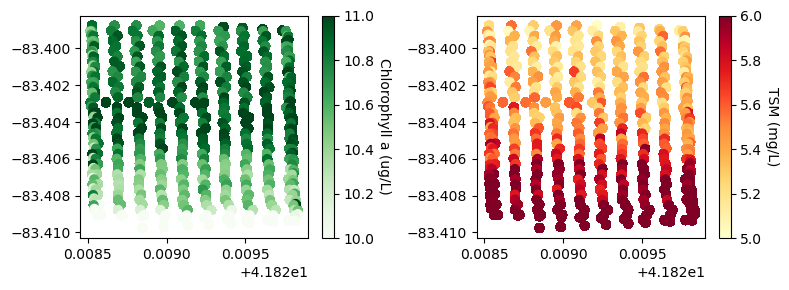

In [57]:
fig, ax = plt.subplots(1,2, figsize=(8,3), layout='tight')
for i in range(len(df)):  
    g1 = ax[0].scatter(df['Latitude'], df['Longitude'], c=df['chl_hu_ocx'], cmap='Greens', vmin=10, vmax=11)
    g2 = ax[1].scatter(df['Latitude'], df['Longitude'], c=df['tsm_nechad'], cmap='YlOrRd', vmin=5, vmax=6)

cbar = fig.colorbar(g1, ax=ax[0])
cbar.set_label('Chlorophyll a (ug/L)', rotation=270, labelpad=12)
cbar = fig.colorbar(g2, ax=ax[1])
cbar.set_label('TSM (mg/L)', rotation=270, labelpad=12)

plt.show()

## 6. Georeference and mosaic chlorophyll a images

We can georeference the images based on the sensor yaw, pitch, roll, lat, lon, and altitude. Note that georeferencing can be inaccurate if the yaw, pitch, and roll information is imprecise. Let's look at the options in the `georeference()` function.

In [60]:
?georeference

Signature:
georeference(
    metadata,
    input_dir,
    output_dir,
    lines=None,
    altitude=None,
    yaw=None,
    pitch=0,
    roll=0,
    axis_to_flip=None,
)
Docstring:
This function georeferences all the captures indicated in the line parameter following the specification of the other parameters such as altitude, yaw, pitch, roll, axis_to_flip

Inputs:
metadata: A Pandas dataframe of the metadata
input_dir: A string containing the directory filepath of the images to be retrieved for georeferencing.
output_dir: A string containing the directory filepath to be saved. 
lines: Selection of images to be processed. Defaults to None. Example: [slice(0,10)]
altitude: sets the altitude where all captures were taken. Defaults to None which uses the altitude data saved in the metadata for each respective capture.
yaw: sets the sensor's direction angle during all captures. Defaults to None which uses the yaw angle saved in the metadata for each respective capture.
pitch: sets the senso

We have two options here. We can set fixed georeferencing parameters, or allow the function to use parameters saved in the metadata.

In this example, the image metadata lists the altitude around 260-265 m; however, the altitude was set at 87 m in the flight planning software. Therefore, we will set the altitude to a fixed altitude of 87 m. 

If you can maintain a consistent sensor yaw angle throughout the whole flight, you should use a single fixed angle. If your sensor changes yaw angle during every transect (such as in this example), a different yaw angle should be provided in the function for each transect. The `georeference()` function can read in a `lines` parameter that can be created either manually or you can use the function `compute_flight_lines()` to automatically produce a list of capture indices per transect with the median yaw angle, ignoring capturing collected during turns. More information can be found in the paper.md. 

In [12]:
metadata = pd.read_csv(os.path.join(project_path, 'metadata.csv'))

flight_lines = compute_flight_lines(metadata.Yaw, 87, 0, 0)
flight_lines[0:5]

[{'start': 11,
  'end': 17,
  'yaw': 22.38186906133012,
  'pitch': 0,
  'roll': 0,
  'alt': 87},
 {'start': 22,
  'end': 32,
  'yaw': 191.33091744718965,
  'pitch': 0,
  'roll': 0,
  'alt': 87},
 {'start': 34,
  'end': 42,
  'yaw': 19.967873657864065,
  'pitch': 0,
  'roll': 0,
  'alt': 87},
 {'start': 46,
  'end': 56,
  'yaw': 190.99810889841936,
  'pitch': 0,
  'roll': 0,
  'alt': 87},
 {'start': 58,
  'end': 66,
  'yaw': 19.47387314726504,
  'pitch': 0,
  'roll': 0,
  'alt': 87}]

In [13]:
metadata = pd.read_csv(os.path.join(project_path, 'metadata.csv'))
input_dir = os.path.join(project_path, 'chl_hu_ocx_imgs') 
output_dir = os.path.join(project_path, 'georeferenced_chl_hu_ocx')
lines = flight_lines

georeference(metadata, input_dir, output_dir, lines) 

100%|██████████| 328/328 [02:22<00:00,  2.31it/s]


Let's plot a few of these georeferenced images

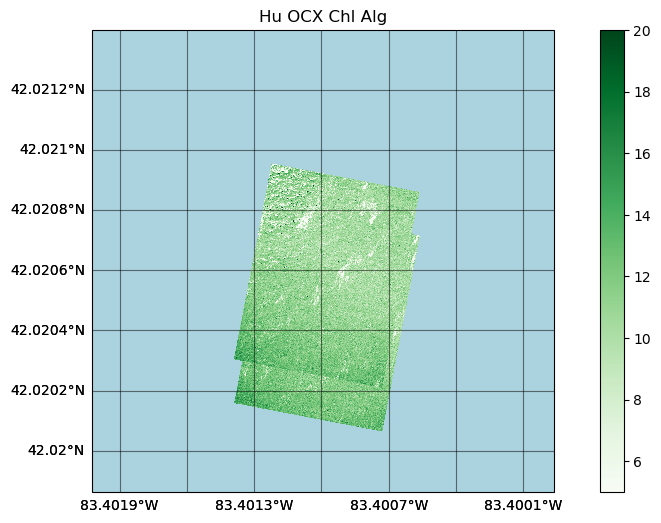

In [63]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 6), subplot_kw = dict(projection = Mercator()))
ax_0, mappable_0 = plot_georeferenced_data(ax=ax, filename="Lake_Erie/georeferenced_chl_hu_ocx/capture_100.tif", 
                                           vmin=5, vmax=20, cmap='Greens', norm=None, basemap = cx.providers.OpenStreetMap.Mapnik)

ax_0, mappable_0 = plot_georeferenced_data(ax=ax, filename="Lake_Erie/georeferenced_chl_hu_ocx/capture_101.tif", 
                                           vmin=5, vmax=20, cmap='Greens', norm=None, basemap = cx.providers.OpenStreetMap.Mapnik)

ax_0.set_title('Hu OCX Chl Alg')
plt.colorbar(mappable_0)


We can mosaic all of the individual georeferenced images. Let's look at the options.

In [63]:
?mosaic

Signature:
mosaic(
    input_dir,
    output_dir,
    output_name,
    method='mean',
    dtype=<class 'numpy.float32'>,
    band_names=None,
)
Docstring:
This function moasics all the given rasters into a single raster file 

Inputs:
input_dir: a string containing the directory filepath of images to be mosaicked 
output_dir: a string containing the directory filepath to save the output
output_name: a string of the output name of mosaicked .tif
method: Method to be used when multiple captures coincide at same location. Options: 'mean', 'first', 'min', 'max'. Defaults to 'mean'.
dtype: dtype of the mosaicked raster. Defaults to np.float32.
band_names: List of band names. If it is not None, it writes one file for each band instead of one file with all the bands. Defaults to None.

Returns:
Mosaicked .tif file
File:      /home/jovyan/utils.py
Type:      function

We will make a mosaic from all the georeferenced chl images, calculating the mean of overlapping pixels. 

In [64]:
input_dir = os.path.join(project_path, 'georeferenced_chl_hu_ocx')
output_dir = os.path.join(project_path, 'mosaic_chl_hu_ocx')

mosaic(input_dir, output_dir, output_name = 'mean_mosaic_chl_hu_ocx',
           method='mean', band_names = None) 

100%|██████████| 328/328 [09:02<00:00,  1.65s/it]


'Lake_Erie/mosaic_chl_hu_ocx/mean_mosaic_chl_hu_ocx.tif'

Now let's plot the mosaicked image.

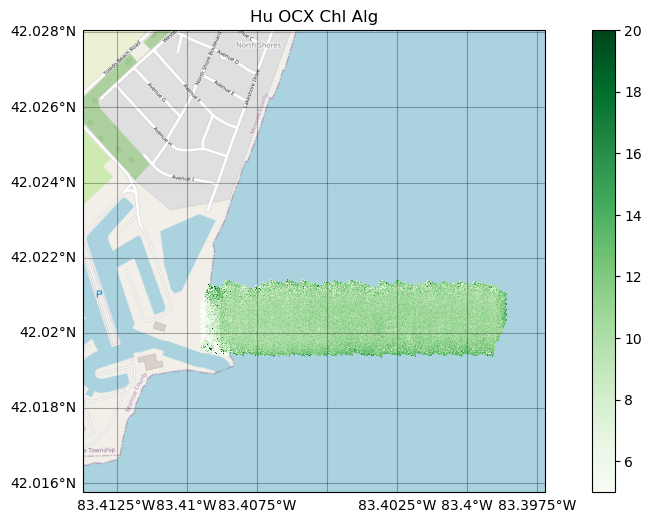

In [66]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 6), subplot_kw = dict(projection = Mercator()))
ax_0, mappable_0 = plot_georeferenced_data(ax=ax, filename="Lake_Erie/mosaic_chl_hu_ocx/mean_mosaic_chl_hu_ocx.tif", 
                                           vmin=5, vmax=20, cmap='Greens', norm=None, basemap = cx.providers.OpenStreetMap.Mapnik)
ax_0.set_title('Hu OCX Chl Alg')
plt.colorbar(mappable_0)

We can also downsample or reduce the spatial resolution of the mosaic. This is helpful to reduce the file size of a large mosaic. 

In [65]:
?downsample

Signature:
downsample(
    input_dir,
    output_dir,
    scale_x,
    scale_y,
    method=<Resampling.average: 5>,
)
Docstring:
This function performs a downsampling to reduce the spatial resolution of the final mosaic. 

Inputs:
input_dir: A string containing input directory filepath  
output_dir: A string containing output directory filepath 
scale_x: proportion by which the width of each file will be resized 
scale_y: proportion by which the height of each file will be resized
method: the resampling method to perform. Defaults to Resampling.average.
File:      /glusteruser/awindled/DroneWQ/utils.py
Type:      function

We will downsample the width and height of the mosaic by 15%, calculating the mean of overlapping pixels.

In [67]:
input_dir = os.path.join(project_path, 'mosaic_chl_hu_ocx')
output_dir = os.path.join(project_path, 'mosaic_chl_hu_ocx')

downsample(input_dir, output_dir, scale_x = 15, scale_y = 15, method = Resampling.average)

100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


And we can plot it

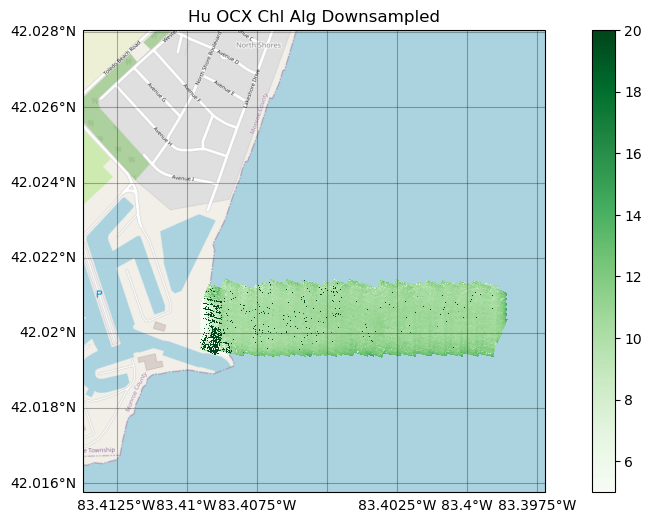

In [68]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 6), subplot_kw = dict(projection = Mercator()))
ax_0, mappable_0 = plot_georeferenced_data(ax=ax, filename="Lake_Erie/mosaic_chl_hu_ocx/mean_mosaic_chl_hu_ocx_x_15_y_15_method_average.tif", 
                                           vmin=5, vmax=20, cmap='Greens', norm=None, basemap = cx.providers.OpenStreetMap.Mapnik)
ax_0.set_title('Hu OCX Chl Alg Downsampled')
plt.colorbar(mappable_0)